In [1]:
import os, sys, time, resource, re, gc, shutil

mp_pdf = False
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
else:
    extension = "png"
    
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *
from copy import deepcopy


from run_id import run_id

run_id = 1056

run_id = 1429

run_id = 1771
#run_id = 1810
#run_id = 1817
run_id = 1861

runstat = RunStats.objects.get(pk=run_id)

if runstat.method=="DT":
    topics = DynamicTopic.objects.filter(run_id=run_id)
else:
    topics = Topic.objects.filter(run_id=run_id)

In [2]:
t = Topic.objects.get(run_id=run_id, title__icontains="membranes")
print(t.primary_wg)
wg2ds = DocTopic.objects.filter(topic=t,doc__PY__lt=2014).order_by('-score')

for d in wg2ds[:10]:
    print()
    print(d.doc.title)
    print(d.doc.PY)
    print(d.doc.content)
    print(d.doc.ipccref_set.all())
    print(d.score)

2

Current status and development of membranes for CO2/CH4 separation: A review
2013
Carbon dioxide (CO2) is a greenhouse gas found primarily as a main combustion product of fossil fuel as well as a component in natural gas, biogas and landfill gas. The interest to remove CO2 from those gas streams to obtain fuel with enhanced energy content and prevent corrosion problems in the gas transportation system, in addition to CO2 implications to the climate change, has driven the development of CO2 separation process technology. One type of technology which has experienced substantial growth, breakthroughs and advances during past decades is membrane-based technology. The attractive features offered by this technology include high energy efficiency, simplicity in design and construction of membrane modules and environmental compatibility. The objective of this review is to overview the different types of membranes available for use including their working principles, current status and devel

In [3]:
t = Topic.objects.get(run_id=run_id, title__icontains="membranes")
print(t.primary_wg)
wg2ds = DocTopic.objects.filter(topic=t,doc__ipccref__wg__wg=2).order_by('-score')

for d in wg2ds[:10]:
    print()
    print(d.doc.title)
    print(d.doc.content)
    print(d.score)

2

Major Cellular and Physiological Impacts of Ocean Acidification on a Reef Building Coral
As atmospheric levels of CO2 increase, reef-building corals are under greater stress from both increased sea surface temperatures and declining sea water pH. To date, most studies have focused on either coral bleaching due to warming oceans or declining calcification due to decreasing oceanic carbonate ion concentrations. Here, through the use of physiology measurements and cDNA microarrays, we show that changes in pH and ocean chemistry consistent with two scenarios put forward by the Intergovernmental Panel on Climate Change (IPCC) drive major changes in gene expression, respiration, photosynthesis and symbiosis of the coral, Acropora millepora, before affects on biomineralisation are apparent at the phenotype level. Under high CO2 conditions corals at the phenotype level lost over half their Symbiodinium populations, and had a decrease in both photosynthesis and respiration. Changes in gene e

In [4]:
if runstat.method=="DT":
    
    tsums = topics.aggregate(
        ip_score=Sum('ipcc_score'),
        score=Sum('ipcc_time_score')
    )
    tsums
    
    topics.update(
        ipcc_share=F('ipcc_score')/tsums['ip_score'],
        share=F('ipcc_time_score')/tsums['score']
    )
    

In [5]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]


In [6]:


if runstat.method=="DT":
    df = pd.DataFrame.from_dict(
        list(topics.values(
            'title',
            'score',
            'ipcc_coverage',
            'share',
            'ipcc_score',
            'ipcc_share',
            'ipcc_time_score',
            'primary_wg'
        ))
    )
else:
    df = pd.DataFrame.from_dict(
        list(topics.values(
            'title',
            'score',
            'ipcc_coverage',
            'share',
            'ipcc_score',
            'ipcc_share',
            'primary_wg'
        ))
    )
    
    
    

df, df_disp  = calculate_deviations(df)


df.sort_values('representation').head()

,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation
37,0.002490,0.114651,0.000038,2,127.780943,0.003469,"membranes, membranes",-0.003430,0.003430,0.011029
22,0.014066,0.613136,0.000205,2,147.331131,0.003999,"adsorption, adsorption (of CO2 for capture)",-0.003795,0.003795,0.051157
91,0.017293,1.019041,0.000340,1,148.161559,0.004022,"absorption, absorption (of CO2 for capture)",-0.003682,0.003682,0.084547
42,0.013214,1.302513,0.000435,3,182.280762,0.004948,"hydrogen, hydrogen fuels",-0.004513,0.004513,0.087838
138,0.019568,2.616900,0.000872,1,302.169759,0.008202,"CLC, chemical looping combustion (CLC)",-0.007331,0.007331,0.106278


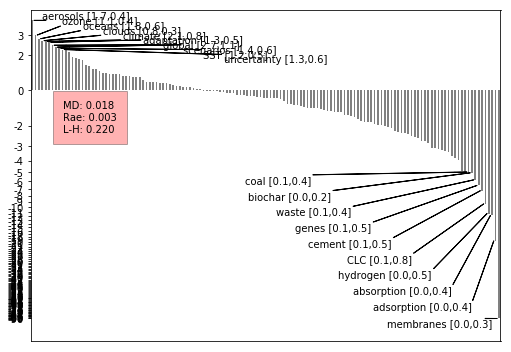

In [7]:

from matplotlib import ticker


plt.rcParams["figure.figsize"] = [7.2,5]

def plot_representation(df, ax, nts=5, xspace=3,yspace = 0.15, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index()#.set_index('title')

    pdf = pdf[pdf['share'] > 0.001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax,color="grey")

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'].split(',')[0],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=((xspace-3)*-1+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'].split(',')[0],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xspace-3-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=10,xspace=6,yspace=0.07)
plt.tight_layout()
if mp_pdf:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.pdf'.format(run_id),bbox_inches='tight')
else:
    plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_all.png'.format(run_id),bbox_inches='tight')
plt.show()

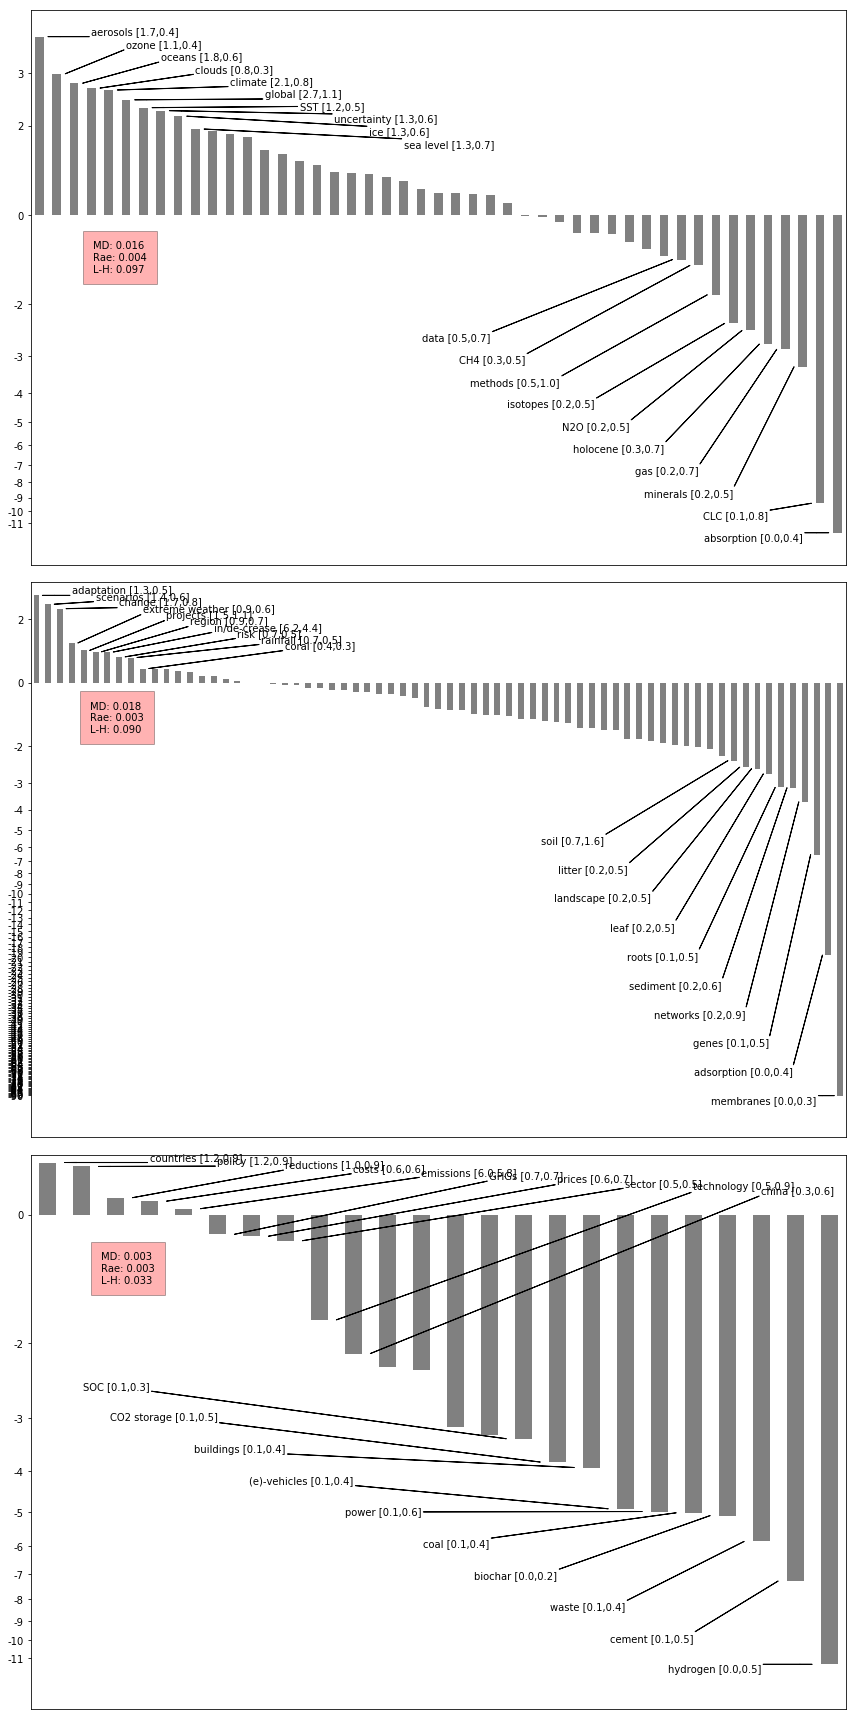

In [8]:
fig, axs = plt.subplots(3, figsize=(12,24))
for i, (name, group) in enumerate(df.groupby('primary_wg')):
    ax = axs[i]
    plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    
plt.tight_layout()
    #plt.savefig(f'../plots/ipcc_representation/ipcc_rep_{run_id}_wg_{}.pdf',bbox_inches='tight')

In [9]:
rmin = -1.5
rmax = 1
lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)

ytick_labels = [i for i in range(lmin,lmax) if i not in [-1,1]]
print(ytick_labels)
yticks = []
for x in ytick_labels:
    if x < 0:
        x = np.log(-1/x)
    elif x==0:
        x = 0
    else:
        x = np.log(x)
    yticks.append(x)
#yticks = [np.log(x) if x!=0 else 0 for x in ytick_labels ]
print(yticks)

[-4, -3, -2, 0]
[-1.3862943611198906, -1.0986122886681098, -0.6931471805599453, 0]


In [10]:
import pandas as pd
if runstat.method=="DT":

    tds = topics.filter(timedtopic__period__n__lt=6).values(
        'title','timedtopic__period__title','timedtopic__period__n','timedtopic__score','score'
    ).order_by('id','timedtopic__period__n')

    tdf = pd.DataFrame.from_dict(list(tds))

    #tdf['ys'] = tdf[]

    tdf['share'] = tdf['timedtopic__score'] / tdf['score']

    tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']


    tdf.head(12)
    #tdf.groupby('')
else:
    topic_period_scores = []
    periods = TimePeriod.objects.filter(title__regex="^AR",n__lt=7,n__gt=0).distinct('title')
    if runstat.periods.count()==0:
        for p in periods:
            runstat.periods.add(p)
    periods = runstat.periods.filter(n__lt=6,n__gt=0).order_by('n')
    ttps = TopicTimePeriodScores.objects.filter(topic__run_id=run_id,score__isnull=False)
    if ttps.count() < (topics.count() * periods.count()-2): 
        print("calculating topictimeperiodscores")
        for p in TimePeriod.objects.filter(title__regex="^AR",n__lt=6,n__gt=0).distinct('title'):
            pdts = DocTopic.objects.filter(
                topic__run_id=run_id,
                doc__PY__in=p.ys
            ).values(
                'topic__title','topic__score'
            ).annotate(
                timedtopic__score = Sum('score')
            )
            for pdt in list(pdts):
                pdt['timedtopic__period__n'] = p.n
                t = Topic.objects.get(run_id=run_id,title=pdt['topic__title'])
                ttps, created = TopicTimePeriodScores.objects.get_or_create(
                    topic=t,
                    period=p
                )
                ttps.score = pdt['timedtopic__score']
                ttps.save()
                topic_period_scores.append(pdt)
        tdf = pd.DataFrame.from_dict(topic_period_scores)
        tdf['share'] = tdf['timedtopic__score'] / tdf['topic__score']

        tdf['ys'] = tdf['timedtopic__period__n'] * tdf['share']     
    else:
        print("getting topictimeperiodscores")
        tds = topics.filter(topictimeperiodscores__period__n__lt=6).values(
            'title','topictimeperiodscores__period__title',
            'topictimeperiodscores__period__n','topictimeperiodscores__score','score'
        ).order_by('id','topictimeperiodscores__period__n')   
        
        tdf = pd.DataFrame.from_dict(list(tds))
            
        tdf['share'] = tdf['topictimeperiodscores__score'] / tdf['score']

        tdf['ys'] = tdf['topictimeperiodscores__period__n'] * tdf['share']
    tdf = tdf.rename(columns={
        "topic__title":"title",
        "topictimeperiodscores__period__n":"timedtopic__period__n"
    }).dropna().reset_index(drop=True)
    
tdf.head()

getting topictimeperiodscores


,score,title,timedtopic__period__n,topictimeperiodscores__period__title,topictimeperiodscores__score,share,ys
0,734.869401,"indices, indices, correlation and relationships",1,AR1,0.196930,0.000268,0.000268
1,734.869401,"indices, indices, correlation and relationships",2,AR2,9.229427,0.012559,0.025119
2,734.869401,"indices, indices, correlation and relationships",3,AR3,34.407065,0.046821,0.140462
3,734.869401,"indices, indices, correlation and relationships",4,AR4,80.093673,0.108990,0.435961
4,734.869401,"indices, indices, correlation and relationships",5,AR5,252.454256,0.343536,1.717681


In [11]:
means = tdf.groupby('title')['ys'].mean()

means = pd.DataFrame({'ys' : tdf.groupby('title')['ys'].mean()}).reset_index()

mdf = df.merge(means)

mdf.head()

means.sort_values('ys',ascending=False).head()



,title,ys
23,"change, climate / land use change",0.894171
138,"years, years, periods & annual variation",0.876699
35,"data, data",0.829690
38,"distribution, shifts in spatial distribution (...",0.778817
21,"causality, attribution of effects",0.774176


In [12]:
def year_av(x):
    group = tdf[tdf['title']==x['title']]
    l = []
    for index, y in group.iterrows():
        l = l + [y.timedtopic__period__n] * round(y.share*100)
    return np.mean(l)

mdf['year_av'] = df.apply(year_av,axis=1)

print(mdf[pd.isna(mdf['year_av'])].shape)

mdf.head()

(0, 12)


,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av
0,0.128797,14.646783,0.004887,2,252.220079,0.006846,"resources, resource management",-0.001959,0.001959,0.713847,0.592992,4.640625
1,0.158433,11.240170,0.003751,2,129.018354,0.003502,"fire, fire",0.000248,0.000248,1.070937,0.546625,4.475410
2,0.176489,27.943361,0.009324,2,302.971623,0.008224,"causality, attribution of effects",0.001100,0.001100,1.133755,0.774176,4.436782
3,0.097683,22.877968,0.007634,1,348.588788,0.009462,"records, long term climate & CO2 records",-0.001828,0.001828,0.806764,0.724605,4.305882
4,0.151926,29.904547,0.009978,1,373.365499,0.010135,"carbon, carbon sources, sinks and flows",-0.000156,0.000156,0.984567,0.558740,4.483871


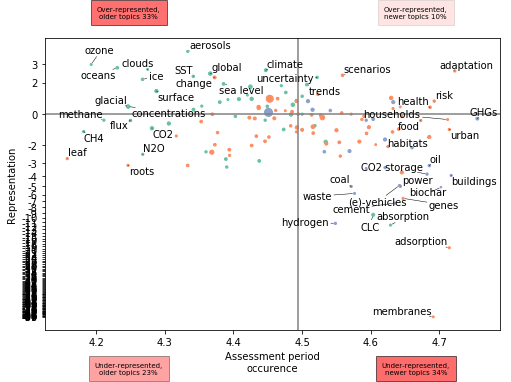

In [13]:
x = 'year_av'
y = 'representation'
y = 'lrep'

mdf['lrep'] = np.log(mdf['representation'])

fig, ax = plt.subplots()

cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


mdf.plot.scatter(
    x,y,s=mdf['score']*0.03,
    c = colors,ax=ax
)


# Fit a trendline
#z = np.polyfit(x=mdf[x], y=mdf[y], deg=1)
#p = np.poly1d(z)
#mdf['trendline'] = p(mdf.loc[:, x])
#plt.plot(mdf[x],mdf['trendline'])


# Quantile x and y
qs = 10
mdf['x_q'] = pd.qcut(mdf[x], qs, labels=False)
mdf['y_q'] = pd.qcut(mdf[y], qs, labels=False)
texts = []

# write texts for dots in outer quantiles
for i, row in mdf[(mdf['x_q'].isin([0,qs-1])) | (mdf['y_q'].isin([0,qs-1]))].iterrows(): 
    t = row['title'].split(',')[0].strip('{} ')
    texts.append(plt.text(row[x],row[y],t,ha='center', va='center'))
    
# Tweak the labels to avoid overlap    
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", color='black', lw=0.5)
)


# Split the graph into quadrants
ymid = 0
plt.axhline(ymid,c="grey")
plt.axvline(mdf[x].median(),c="grey")



# Put labels on the quadrants
# x
d1 = mdf[x].median()-plt.xlim()[0]
d2 = mdf[x].median()-plt.xlim()[1]

xlabpoints = [mdf[x].median()-d1/2,mdf[x].median()-d2/2]
xrange = mdf[x].max()-mdf[x].min()
xlabpoints = [mdf[x].min()+xrange*0.15,mdf[x].min()+xrange*0.85]
labels = [
    ['Under-represented,\nolder topics','Under-represented,\nnewer topics'],
    ['Over-represented,\nolder topics','Over-represented,\nnewer topics']
]

pylims = plt.ylim()

tpad = (pylims[1]-pylims[0])*0.13


ops = [operator.lt,operator.gt]


for i in [0,1]:
    for j in [0,1]:
        if j==0:
            tpadx=tpad*-1
        else:
            tpadx=tpad*0.66

            
        q = mdf[(ops[i](mdf[x],mdf[x].median())) & (ops[j](mdf[y],ymid))]
        qshare = q['score'].sum()/mdf['score'].sum()
        plt.text(
            xlabpoints[i],
            pylims[j]+tpadx,
            labels[j][i] + " {:.0%}".format(qshare),
            va="center",ha="center",
            bbox={'facecolor':'red', 'alpha':qshare*2-0.1, 'pad':6},
            fontsize=7
        )

        
fmax = None
fmin = None
rmax = mdf['lrep'].max()
if fmax:
    rmax = fmax
rmin = mdf['lrep'].min()
if fmin:
    rmin = -fmin
    
if rmin > -1:
    rmin = -1
if np.exp(rmax) < 2:
    rmax = np.log(2.1)

lmin = int(1/np.exp(rmin)//1)*-1
lmax = int(np.exp(rmax)//1)



ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
yticks = []
for x in ytick_labels:
    if x < 0:
        y = np.log(-1/x)
    elif x==0:
        y = 0
    else:
        y = np.log(x)
    yticks.append(y)
    
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

#ax.get_yaxis().set_visible(False)
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax2.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Assessment period\noccurence')
plt.ylabel('Representation')

plt.tight_layout(h_pad=100)

fig.patch.set_facecolor('white')    


plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_new{}_all.{}'.format(run_id,extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

plt.show()

In [14]:
mdf.to_csv(f'../tables/newness_representation_{run_id}.csv',index=False)

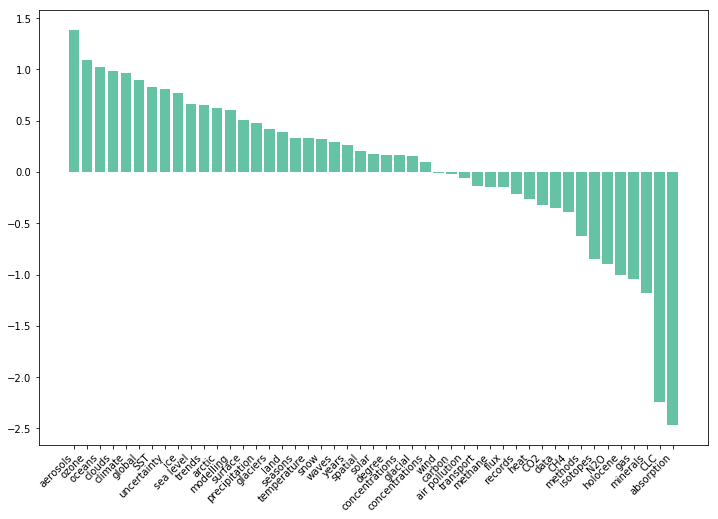

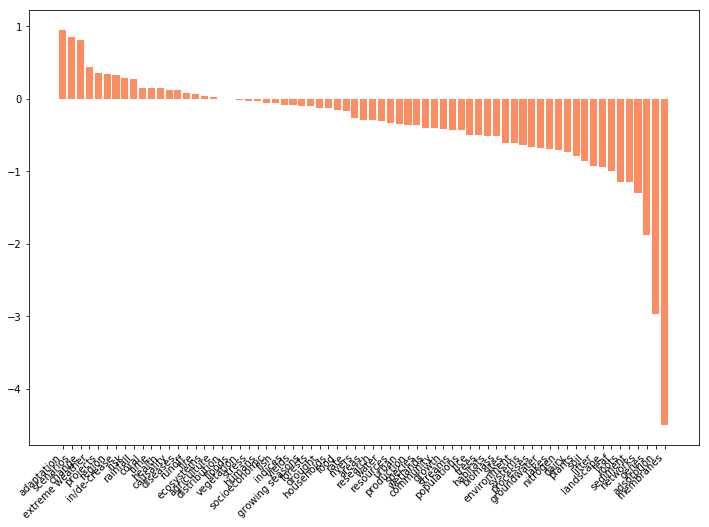

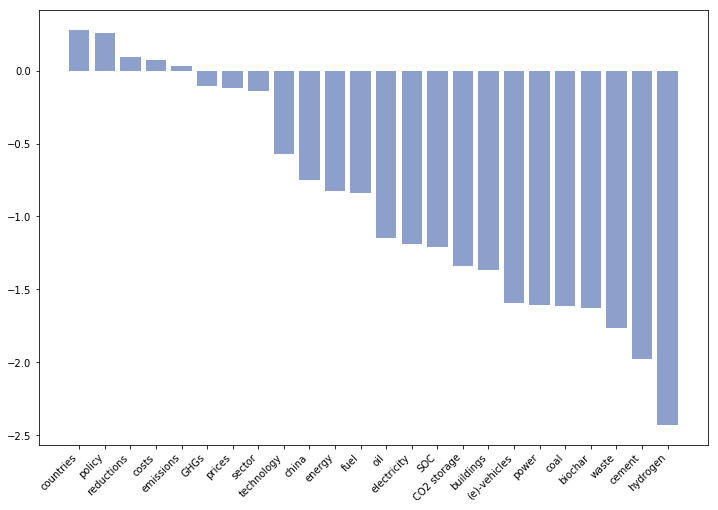

In [15]:
for name, group in mdf.groupby('primary_wg'):
    group = group.sort_values('lrep', ascending=False).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(12,8))
    
    #plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    plt.xticks(rotation=45,ha="right")
    ax.bar(group.index, group['lrep'], color=cmap[group['primary_wg'][0]])
    ax.set_xticks(group.index)
    ax.set_xticklabels([x.split(',')[0] for x in group['title']])
    fig.patch.set_facecolor('white') 
    
    plt.savefig(
        '../plots/ipcc_representation/ipcc_rep_wg_{}_{}_all.{}'.format(name,run_id,extension),
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )
    
    plt.show()
    

In [16]:
mdf.sort_values('year_av', ascending=False).tail(15)

,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation,ys,year_av,lrep,x_q,y_q
3,0.097683,22.877968,0.007634,1,348.588788,0.009462,"records, long term climate & CO2 records",-0.001828,0.001828,0.806764,0.724605,4.305882,-0.214724,1,4
7,0.215807,46.446001,0.015498,1,343.995170,0.009338,"surface, surface & albedo",0.006160,0.006160,1.659734,0.626493,4.287671,0.506657,0,8
132,0.106370,22.343198,0.007433,1,376.947298,0.010232,"CO2, CO2",-0.002799,0.002799,0.726462,0.541091,4.281250,-0.319569,0,4
14,0.323435,24.912668,0.008313,1,114.395218,0.003105,"clouds, cloud radiative feedback",0.005208,0.005208,2.677039,0.684981,4.275000,0.984711,0,9
127,0.060700,5.436405,0.001842,1,166.657815,0.004524,"N2O, N2O emissions and nitrogen cycle",-0.002682,0.002682,0.407112,0.474343,4.267857,-0.898667,0,1
119,0.246623,38.166111,0.012804,1,219.207563,0.005950,"ice, ice sheets, ice cover",0.006853,0.006853,2.151775,0.602005,4.267606,0.766293,0,9
118,0.107533,14.900452,0.004965,1,211.939167,0.005753,"flux, flux measurement",-0.000788,0.000788,0.862972,0.680129,4.250000,-0.147374,0,4
50,0.137191,24.106715,0.008044,1,253.102125,0.006870,"glacial, glacial periods",0.001173,0.001173,1.170805,0.729562,4.247059,0.157692,0,7
62,0.044872,4.334261,0.001446,2,167.108271,0.004536,"roots, root dynamics",-0.003090,0.003090,0.318830,0.581997,4.246377,-1.143096,0,1
43,0.155120,37.120384,0.012386,1,387.272549,0.010512,"concentrations, atmospheric & plant concentrat...",0.001874,0.001874,1.178252,0.585644,4.246377,0.164032,0,7


In [17]:
mdf = mdf.sort_values(['primary_wg','year_av'],ascending=False).reset_index(drop=True)

mdf.head()

mdf[['ipcc_share','share','representation','primary_wg','title','year_av']].to_latex(
    '../tables/ipcc_shares_time.tex',
    index_names=False,
)

In [18]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']

oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    #{'wc__oecd': None}
]

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(oecd_cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd=c['wc__oecd'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[i]
    
oecd_df = pd.DataFrame.from_dict(oecd_cats)

oecd_df.head()

,color,ipcc_share,share,wc__oecd
0,#7fc97f,0.050116,0.107608,Agricultural Sciences
1,#beaed4,0.067244,0.247342,Engineering and Technology
2,#fdc086,0.001448,0.007933,Humanities
3,#ffff99,0.018612,0.019410,Medical and Health Sciences
4,#386cb0,0.802687,0.701151,Natural Sciences


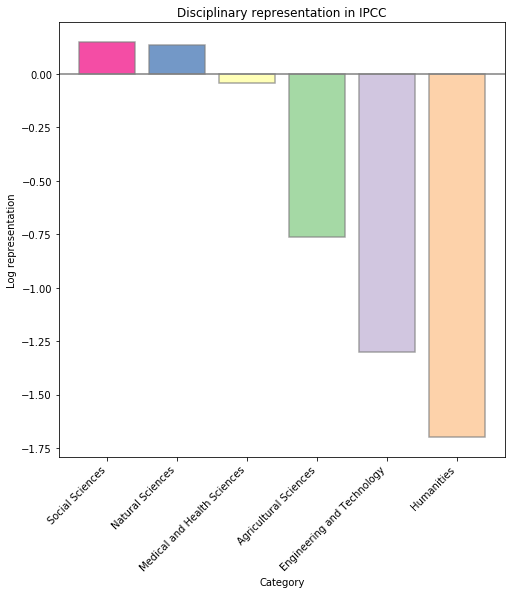

In [19]:
oecd_df['representation'] = oecd_df['ipcc_share'] / oecd_df['share']

oecd_df['lrep'] = np.log(oecd_df['representation'])

oecd_df = oecd_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    oecd_df.index, 
    oecd_df['lrep'],
    color=oecd_df['color'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey"
)

ax.set_xticks(oecd_df.index)
ax.set_xticklabels(oecd_df['wc__oecd'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('white')    


In [20]:
q = runstat.query
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
oecd_cats = [
    {'wc__oecd': 'Agricultural Sciences'},
    {'wc__oecd': 'Engineering and Technology'},
    {'wc__oecd': 'Humanities'},
    {'wc__oecd': 'Medical and Health Sciences'},
    {'wc__oecd': 'Natural Sciences'},
    {'wc__oecd': 'Social Sciences'},
    {'wc__oecd': None}
]



oecd_df = pd.DataFrame()

ar_oe_cats = []

all_docs_count =  Doc.objects.filter(query=q).count()

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(oecd_cats):
        d = {"wc__oecd": c["wc__oecd"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd=c['wc__oecd'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        all_ars_share = Doc.objects.filter(query=q,wc__oecd=c['wc__oecd']).count() / all_docs_count
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[i]
        d['total_share'] = all_ars_share
        
        ar_oe_cats.append(d)

oecd_df_ys = pd.DataFrame.from_dict(ar_oe_cats)

oecd_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,share,total_share,wc__oecd
0,1,#7fc97f,0.022727,0.095973,0.102866,Agricultural Sciences
1,1,#beaed4,0.022727,0.093402,0.260545,Engineering and Technology
2,1,#fdc086,0.000000,0.023136,0.009045,Humanities
3,1,#ffff99,0.000000,0.018852,0.018990,Medical and Health Sciences
4,1,#386cb0,0.988636,0.899743,0.658729,Natural Sciences


In [21]:
oecd_df_ys['representation'] = oecd_df_ys['ipcc_share'] / oecd_df_ys['share']

oecd_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,share,total_share,wc__oecd,representation
2,1,#fdc086,0.000000,0.023136,0.009045,Humanities,0.000000
3,1,#ffff99,0.000000,0.018852,0.018990,Medical and Health Sciences,0.000000
16,3,#fdc086,0.000000,0.005894,0.009045,Humanities,0.000000
5,1,#f0027f,0.000000,0.044559,0.101383,Social Sciences,0.000000
6,1,#F0F0F0,0.000000,0.002571,0.001772,None,0.000000
9,2,#fdc086,0.000000,0.003982,0.009045,Humanities,0.000000
34,5,#F0F0F0,0.000073,0.000469,0.001772,None,0.156749
27,4,#F0F0F0,0.000280,0.001316,0.001772,None,0.212955
0,1,#7fc97f,0.022727,0.095973,0.102866,Agricultural Sciences,0.236810
30,5,#fdc086,0.002130,0.008823,0.009045,Humanities,0.241467


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


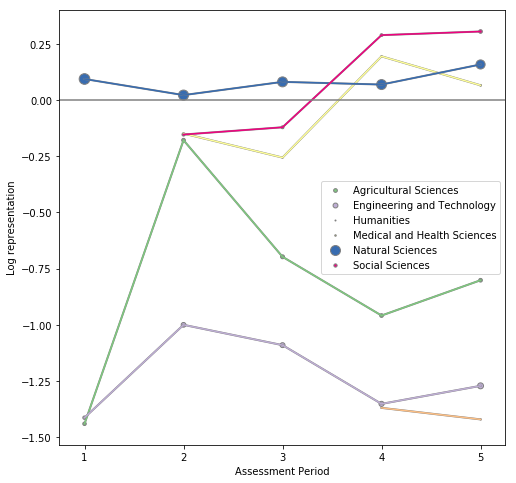

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

fdf = oecd_df_ys

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')

for name, group in fdf.groupby('wc__oecd'):
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    ax.plot(
        group['ar'],
        group['lrep'],
        label='_nolegend_',
        lw=2,
        color="grey"
    )
    ax.plot(
        group['ar'],
        group['lrep'],
        #label=name,
        label='_nolegend_',
        color=color
    )
    ax.scatter(
        group['ar'],
        group['lrep'],
        label=name,
        color=color,
        s = 150*group['s_share'],
        edgecolor="grey"
    )
    
    ax.set_xticks([1,2,3,4,5])
    
ax.axhline(0,c="grey")
    
plt.legend()


ax.set_xlabel('Assessment Period')
ax.set_ylabel('Log representation')

fig.patch.set_facecolor('white')    

plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_time.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


In [23]:
cats = list(WC.objects.distinct('oecd_fos_text').values('oecd_fos_text','oecd_fos','oecd'))
cats

[{'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Agriculture, forestry, and fisheries'},
 {'oecd': 'Agricultural Sciences',
  'oecd_fos': '4',
  'oecd_fos_text': 'Animal and dairy science'},
 {'oecd': 'Humanities',
  'oecd_fos': '6',
  'oecd_fos_text': 'Art (arts, history of arts, performing arts, music)'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Basic medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Biological sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Chemical engineering'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Chemical sciences'},
 {'oecd': 'Engineering and Technology',
  'oecd_fos': '2',
  'oecd_fos_text': 'Civil engineering'},
 {'oecd': 'Medical and Health Sciences',
  'oecd_fos': '3',
  'oecd_fos_text': 'Clinical medicine'},
 {'oecd': 'Natural Sciences',
  'oecd_fos': '1',
  'oecd_fos_text': 'Computer and 

In [24]:
q = runstat.query
colors = ['#386cb0','#beaed4','#ffff99','#7fc97f','#f0027f','#fdc086','#F0F0F0']

d_count = Doc.objects.filter(query=q,PY__lte=AR.objects.get(ar=5).end).count()

ip_d_count = Doc.objects.filter(query=q, ipccref__isnull=False).count()

oecd_df = pd.DataFrame()
for i,c in enumerate(cats):
    ds = Doc.objects.filter(
        query=q,
        wc__oecd_fos_text=c['oecd_fos_text'],
        PY__lte=AR.objects.get(ar=5).end
    )
    ipds = ds.filter(ipccref__isnull=False)
    c['share'] = ds.count() / d_count
    c['ipcc_share'] = ipds.count() / ip_d_count
    c['color'] = colors[int(c['oecd_fos'])-1]
    all_ars_share = Doc.objects.filter(query=q,wc__oecd_fos_text=c['oecd_fos_text']).count() / all_docs_count
    c['total_share'] = all_ars_share
    
    
cat_df = pd.DataFrame.from_dict(cats)

cat_df.head()

,color,ipcc_share,oecd,oecd_fos,oecd_fos_text,share,total_share
0,#7fc97f,0.041208,Agricultural Sciences,4,"Agriculture, forestry, and fisheries",0.089628,0.084901
1,#7fc97f,0.002390,Agricultural Sciences,4,Animal and dairy science,0.005297,0.005216
2,#fdc086,0.000072,Humanities,6,"Art (arts, history of arts, performing arts, m...",0.002002,0.002228
3,#ffff99,0.000833,Medical and Health Sciences,3,Basic medicine,0.002486,0.002763
4,#386cb0,0.122103,Natural Sciences,1,Biological sciences,0.184301,0.174327


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


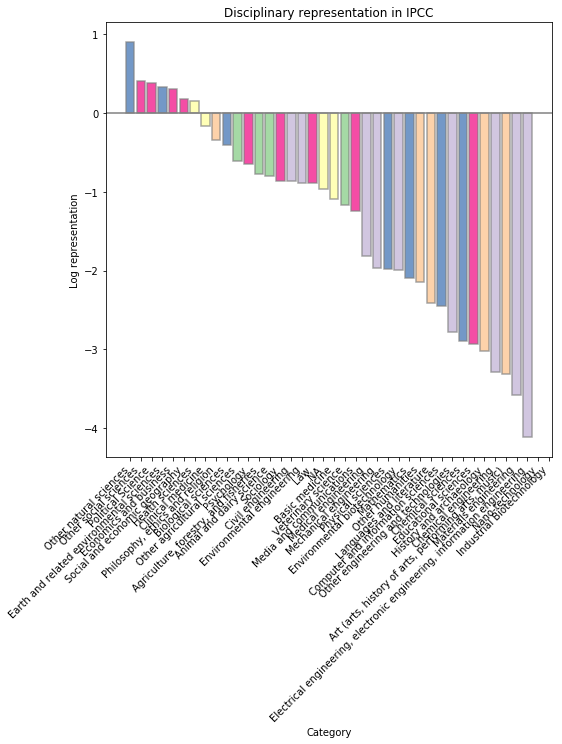

In [25]:
cat_df['representation'] = cat_df['ipcc_share'] / cat_df['share']

cat_df['lrep'] = np.log(cat_df['representation'])

cat_df = cat_df.sort_values('representation', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,8))

ax.bar(
    cat_df.index, 
    cat_df['lrep'],
    alpha=0.7,
    linewidth=1.5,
    edgecolor="grey",
    color=cat_df['color']
)

ax.set_xticks(cat_df.index)
ax.set_xticklabels(cat_df['oecd_fos_text'])

ax.set_xlabel('Category')
ax.set_ylabel('Log representation')

ax.axhline(0,c="grey")

ax.set_title("Disciplinary representation in IPCC")

plt.xticks(rotation=45,ha="right")

fig.patch.set_facecolor('white')    


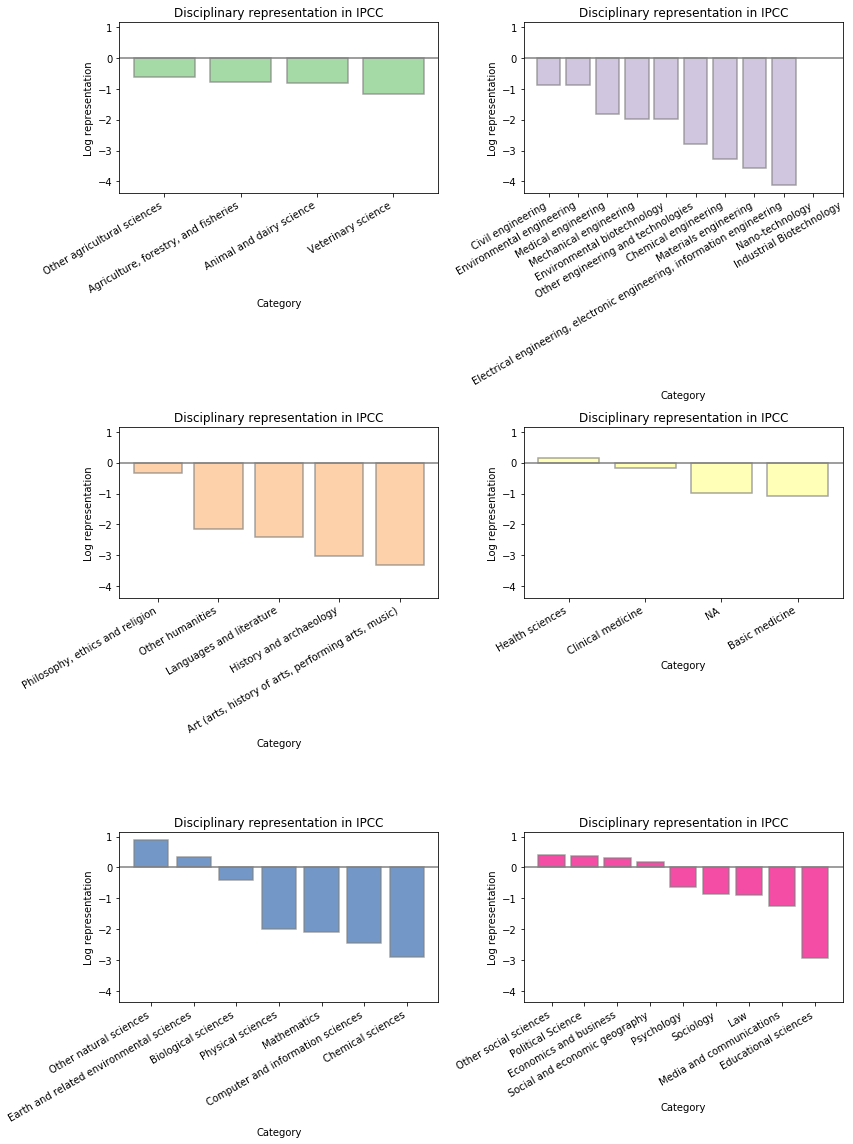

In [26]:
fig = plt.figure(figsize=(12,16))

ax = None

for i, (name, group) in enumerate(cat_df.groupby('oecd')):
    if ax:
        ax = fig.add_subplot(3,2,i+1, sharey=ax)
    else:
        ax = fig.add_subplot(3,2,i+1)
    group = group.reset_index(drop=True)
    ax.bar(
        group.index, 
        group['lrep'],
        alpha=0.7,
        linewidth=1.5,
        edgecolor="grey",
        color=group['color']
    )

    ax.set_xticks(group.index)
    ax.set_xticklabels(group['oecd_fos_text'])
    

    ax.set_xlabel('Category')
    ax.set_ylabel('Log representation')

    ax.axhline(0,c="grey")

    ax.set_title("Disciplinary representation in IPCC")

    plt.xticks()

    fig.patch.set_facecolor('white')    

    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
fig.tight_layout()


plt.savefig(
    f'../plots/ipcc_representation/ipcc_subcats.{extension}',
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)

In [27]:
q = runstat.query

cat_df = pd.DataFrame()

ar_cats = []

for ar in AR.objects.filter(ar__gt=0,ar__lt=6).order_by('ar'):
    print(ar)
    ys = range(ar.start,ar.end+1)
    d_count = Doc.objects.filter(query=q, PY__in=ys).count()
    ip_d_count = Doc.objects.filter(query=q, PY__in=ys, ipccref__isnull=False).count()
    for i,c in enumerate(cats):
        d = {"oecd_fos_text": c["oecd_fos_text"]}
        ds = Doc.objects.filter(
            query=q,
            wc__oecd_fos_text=c['oecd_fos_text'],
            PY__in=ys,
            PY__lte=AR.objects.get(ar=5).end
        )
        ipds = ds.filter(ipccref__isnull=False)
        d['oecd'] = c['oecd']
        d['ar'] = ar.ar
        d['share'] = ds.count() / d_count
        d['ipcc_share'] = ipds.count() / ip_d_count
        d['color'] = colors[int(c['oecd_fos'])-1]
        all_ars_share = Doc.objects.filter(query=q,wc__oecd_fos_text=c['oecd_fos_text']).count() / all_docs_count
        d['total_share'] = all_ars_share
        
        
        ar_cats.append(d)

cat_df_ys = pd.DataFrame.from_dict(ar_cats)

cat_df_ys.head()

1
2
3
4
5


,ar,color,ipcc_share,oecd,oecd_fos_text,share,total_share
0,1,#7fc97f,0.017045,Agricultural Sciences,"Agriculture, forestry, and fisheries",0.083119,0.084901
1,1,#7fc97f,0.000000,Agricultural Sciences,Animal and dairy science,0.003428,0.005216
2,1,#fdc086,0.000000,Humanities,"Art (arts, history of arts, performing arts, m...",0.000857,0.002228
3,1,#ffff99,0.000000,Medical and Health Sciences,Basic medicine,0.003428,0.002763
4,1,#386cb0,0.034091,Natural Sciences,Biological sciences,0.069409,0.174327


In [28]:
cat_df_ys['representation'] = cat_df_ys['ipcc_share'] / cat_df_ys['share']

cat_df_ys.sort_values('representation').head(15)

,ar,color,ipcc_share,oecd,oecd_fos_text,share,total_share,representation
58,2,#beaed4,0.0,Engineering and Technology,Industrial Biotechnology,0.000351,0.000162,0.0
43,2,#ffff99,0.0,Medical and Health Sciences,Basic medicine,0.002108,0.002763,0.0
107,3,#beaed4,0.0,Engineering and Technology,Nano-technology,0.000092,0.001380,0.0
139,4,#fdc086,0.0,Humanities,Languages and literature,0.000129,0.000647,0.0
105,3,#beaed4,0.0,Engineering and Technology,Medical engineering,0.000276,0.000436,0.0
49,2,#386cb0,0.0,Natural Sciences,Computer and information sciences,0.002459,0.016588,0.0
52,2,#f0027f,0.0,Social Sciences,Educational sciences,0.001054,0.003446,0.0
53,2,#beaed4,0.0,Engineering and Technology,"Electrical engineering, electronic engineering...",0.007963,0.025049,0.0
54,2,#beaed4,0.0,Engineering and Technology,Environmental biotechnology,0.002459,0.005976,0.0
57,2,#fdc086,0.0,Humanities,History and archaeology,0.001405,0.002807,0.0


In [29]:
fdf['share'].sum()

5.932811184871515

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_la

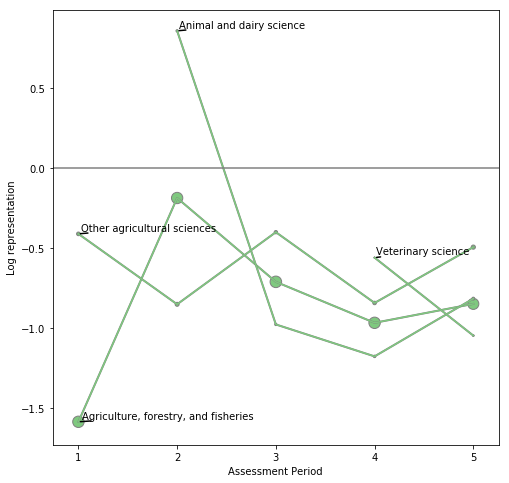

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

empty group


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

empty group


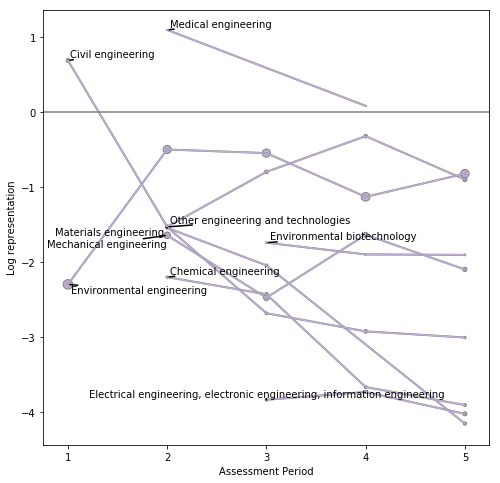

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

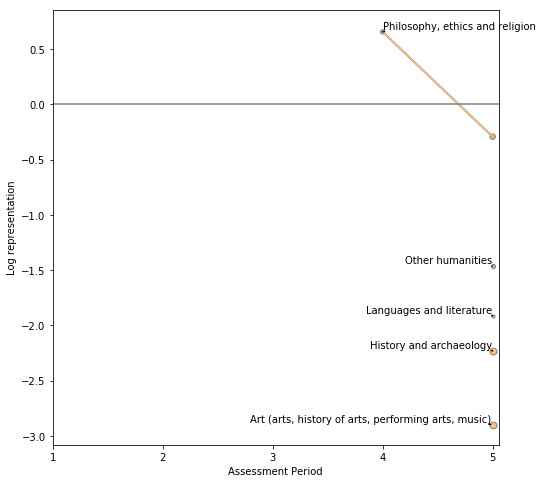

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

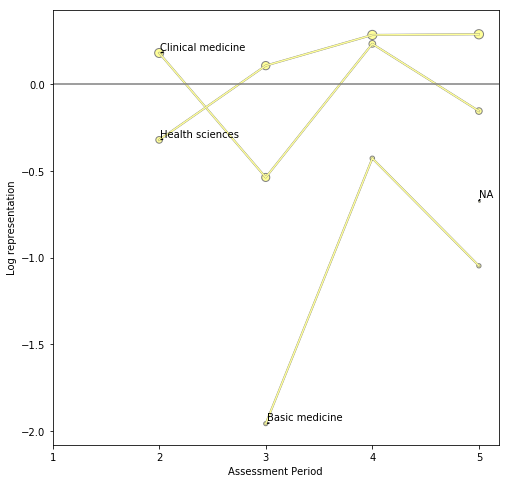

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

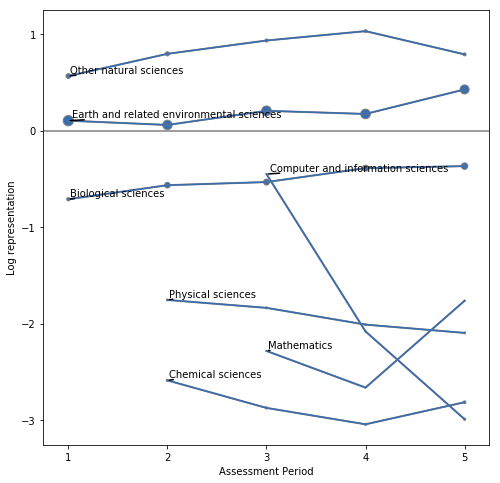

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

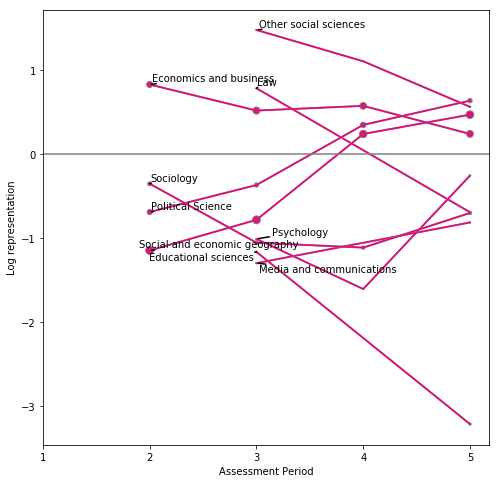

In [30]:

cat_df_ys['lrep'] = np.log(cat_df_ys['representation'])


for dis, fdf in cat_df_ys.groupby('oecd'):
    fig, ax = plt.subplots(figsize=(8,8))
    texts = []
    fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')
    
    for name, group in fdf.groupby('oecd_fos_text'):
        group['s_share'] = group['share'] / group['ar_share_total']
        group = group[np.isfinite(group['lrep'])].sort_values('ar').reset_index(drop=True)
        
        if len(group) == 0:
            print("empty group")
            continue

        color = group.reset_index()['color'][0]
        ax.plot(
            group['ar'],
            group['lrep'],
            label='_nolegend_',
            lw=2,
            color="grey"
        )
        ax.plot(
            group['ar'],
            group['lrep'],
            label=name,
            color=color
        )
        ax.scatter(
            group['ar'],
            group['lrep'],
            label=name,
            color=color,
            s = 150*group['s_share'],
            edgecolor="grey"
        )
        x = group['ar'][0] 
        y = group['lrep'][0]
        if np.isfinite(y):
            texts.append(
            ax.text(
                x,y,
                name
            )
            )

    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle="-", color='black', lw=1.5)
    )

    ax.set_xticks([1,2,3,4,5])

    ax.axhline(0,c="grey")

    #plt.legend()


    ax.set_xlabel('Assessment Period')
    ax.set_ylabel('Log representation')

    fig.patch.set_facecolor('white')    

    plt.savefig(
        f'../plots/ipcc_representation/ipcc_rep_cats_time_{dis}.{extension}',
        bbox_inches='tight',
        facecolor=fig.get_facecolor(),
        pad_inches=0.2
    )
    
    plt.show()
    plt.close()


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Humanities (0.9%)
Medical and Health Sciences (1.9%)
Social Sciences (10.1%)
Agricultural Sciences (10.3%)
Engineering and Technology (26.1%)
Natural Sciences (65.9%)


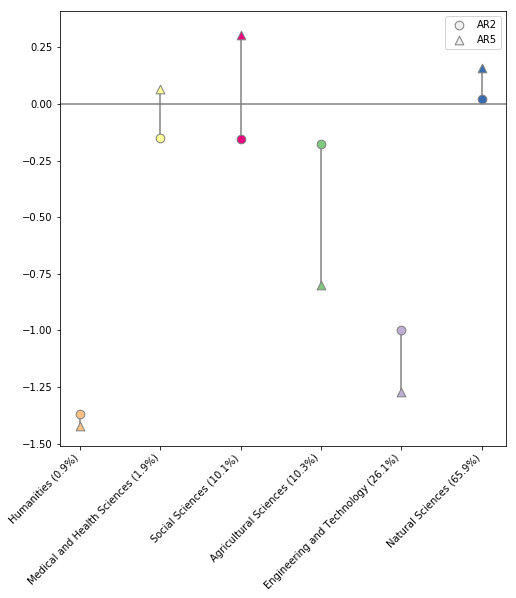

In [31]:
fig, ax = plt.subplots(figsize=(8,8))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

oecd_df_ys.to_csv(f'../tables/oecd_representation_{run_id}.csv',index=False)

fdf = oecd_df_ys[oecd_df_ys['ar']>1]

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')


ticks = []
labels = []

for i, (name, group) in enumerate(fdf.sort_values('total_share').groupby('wc__oecd', sort=False)):
    group = group.replace(-np.inf, np.nan).dropna().sort_values('ar').reset_index(drop=True)
    name = f"{name} ({group['total_share'][0]:.1%})"
    print(name)
    ticks.append(i)
    labels.append(name)
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    
    start = group['lrep'][0]
    end = group['lrep'][len(group)-1]
    size = 75
    ax.plot(
        [i,i],
        [start,end],
        color="grey",
        zorder=-50
    )
    ax.scatter(
        i,
        start,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        #marker="x"
    )
    ax.scatter(
        i,
        end,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        marker="^"
    )
    
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels, ha="right", rotation=45)
ax.axhline(0,c="grey")

for l in [("AR2","o"),("AR5","^")]:
    ax.scatter(
        [],[],
        c='#f0f0f0',s=size,
        edgecolor="grey",
        label=l[0],marker=l[1]
    )

ax.legend()

fig.patch.set_facecolor('white') 


plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_simplified.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)


plt.show()



In [32]:
fdf.sort_values('total_share')

,ar,color,ipcc_share,share,total_share,wc__oecd,representation,lrep,ar_share_total
20,3,#F0F0F0,0.000403,0.000967,0.001772,None,0.416974,-0.874732,1.193866
27,4,#F0F0F0,0.000280,0.001316,0.001772,None,0.212955,-1.546674,1.188692
13,2,#F0F0F0,0.000700,0.001757,0.001772,None,0.398646,-0.919681,1.204239
34,5,#F0F0F0,0.000073,0.000469,0.001772,None,0.156749,-1.853110,1.167779
9,2,#fdc086,0.000000,0.003982,0.009045,Humanities,0.000000,-inf,1.204239
16,3,#fdc086,0.000000,0.005894,0.009045,Humanities,0.000000,-inf,1.193866
30,5,#fdc086,0.002130,0.008823,0.009045,Humanities,0.241467,-1.421021,1.167779
23,4,#fdc086,0.001541,0.006064,0.009045,Humanities,0.254187,-1.369686,1.188692
24,4,#ffff99,0.017377,0.014296,0.018990,Medical and Health Sciences,1.215458,0.195121,1.188692
31,5,#ffff99,0.023876,0.022348,0.018990,Medical and Health Sciences,1.068387,0.066150,1.167779


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Humanities (0.9%)
Medical and Health Sciences (1.9%)
Social Sciences (10.1%)
Agricultural Sciences (10.3%)
Engineering and Technology (26.1%)
Natural Sciences (65.9%)


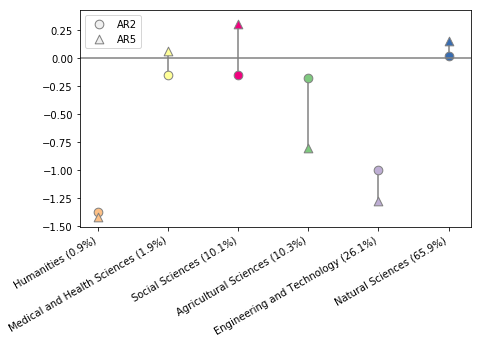

In [33]:
fig, ax = plt.subplots(figsize=(7,4))

oecd_df_ys['lrep'] = np.log(oecd_df_ys['representation'])

fdf = oecd_df_ys[oecd_df_ys['ar']>1]

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')


ticks = []
labels = []

for i, (name, group) in enumerate(fdf.sort_values('total_share').groupby('wc__oecd', sort=False)):
    group = group.replace(-np.inf, np.nan).dropna().sort_values('ar').reset_index(drop=True)
    name = f"{name} ({group['total_share'][0]:.1%})"
    print(name)
    ticks.append(i)
    labels.append(name)
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    
    start = group['lrep'][0]
    end = group['lrep'][len(group)-1]
    size = 75
    ax.plot(
        [i,i],
        [start,end],
        color="grey",
        zorder=-50
    )
    ax.scatter(
        i,
        start,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        #marker="x"
    )
    ax.scatter(
        i,
        end,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        marker="^"
    )
    
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.axhline(0,c="grey")

fig.patch.set_facecolor('white') 

for l in [("AR2","o"),("AR5","^")]:
    ax.scatter(
        [],[],
        c='#f0f0f0',s=size,
        edgecolor="grey",
        label=l[0],marker=l[1]
    )

ax.legend()#loc="lower center")

plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_oecds_simplified_short.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)
#ax.legend(handles=legend_elements, loc="lower center")

plt.show()


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Media and communications (0.1%)
Other social sciences (0.2%)
Psychology (0.2%)
Law (0.2%)
Educational sciences (0.3%)
Sociology (0.8%)
Political Science (1.0%)
Economics and business (3.1%)
Social and economic geography (4.3%)


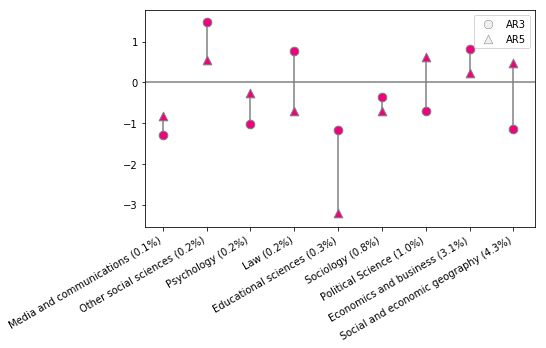

In [34]:
fig, ax = plt.subplots(figsize=(7,4))

fdf = cat_df_ys[cat_df_ys['oecd']=="Social Sciences"]

fdf = fdf[fdf['ar']>1]

fdf['ar_share_total'] = fdf.groupby('ar')['share'].transform('sum')
fdf['lrep'] = np.log(fdf['representation'])




ticks = []
labels = []

for i, (name, group) in enumerate(fdf.sort_values('total_share').groupby('oecd_fos_text', sort=False)):
    group = group.replace(-np.inf, np.nan).dropna().sort_values('ar').reset_index(drop=True)
    name = f"{name} ({group['total_share'][0]:.1%})"
    print(name)
    ticks.append(i)
    labels.append(name)
    color = group.reset_index()['color'][0]
    group['s_share'] = group['share'] / group['ar_share_total']
    
    start = group['lrep'][0]
    end = group['lrep'][len(group)-1]
    size = 75
    ax.plot(
        [i,i],
        [start,end],
        color="grey",
        zorder=-50
    )
    ax.scatter(
        i,
        start,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        #marker="x"
    )
    ax.scatter(
        i,
        end,
        label=None,
        color=color,
        s = size,
        edgecolor="grey",
        marker="^"
    )
    
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels, ha="right", rotation=30)
ax.axhline(0,c="grey")

fig.patch.set_facecolor('white') 

for l in [("AR3","o"),("AR5","^")]:
    ax.scatter(
        [],[],
        c='#f0f0f0',s=size,
        edgecolor="grey",
        lw=0.5,
        label=l[0],marker=l[1]
    )

ax.legend()#loc="lower center")

plt.savefig(
    '../plots/ipcc_representation/ipcc_rep_socsci_simplified_short.{}'.format(extension),
    bbox_inches='tight',
    facecolor=fig.get_facecolor(),
    pad_inches=0.2
)
#ax.legend(handles=legend_elements, loc="lower center")

plt.show()

    


In [35]:
cat_df_ys.to_csv(f'../tables/wc_representation_{run_id}.csv',index=False)
